# Named Entity Identification Using SVM Classifier
This notebook implements an SVM-based Named Entity Identification system using the CoNLL-2003 dataset and custom feature engineering.

**Input**: A sentence.  
**Output**: Each word labeled as Name (1) or No Name (0).

**Example**:  
- **Input**: "Washington DC is the capital of United States of America"  
- **Output**: "Washington_1 DC_1 is_0 the_0 capital_0 of_0 United_1 States_1 of_0 America_1"

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:

dataset = {'train':[{'id':x['id'],'tokens':x['tokens'],'ner_tags':x['ner_tags']} for x in dataset['train']],'test':[{'id':x['id'],'tokens':x['tokens'],'ner_tags':x['ner_tags']} for x in dataset['test']]}
print(dataset['train'][0])
train_data = [(x['tokens'],x['ner_tags']) for x in dataset['train']]

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [ ]:
sent = dataset['train'][0]
word = sent['tokens'][0]
print(sent)
print(word)

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}
EU


In [ ]:
percentage_dict = [0 for _ in range(101)]
percentage_indices = [[] for _ in range(101)]
for sent in dataset['train']:
    tags = sent['ner_tags']
    percent = 100-(tags.count(0)*100)//len(tags)
    percentage_dict[percent]+=1
    percentage_indices[percent].append(int(sent['id']))

In [ ]:
#print(*[(i,j) for i,j in percentage_dict.items()],sep='\n')
from matplotlib import pyplot as plt
%matplotlib inline

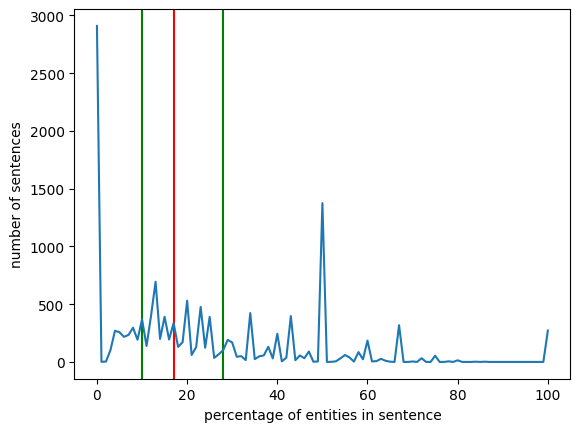

Number of sentence with more than 50% of words as entites is 2560


In [ ]:
total_sents = sum(percentage_dict)
sent_count = half = third = two_third = 0

for i in range(0,101):
    sent_count += percentage_dict[i]
    if not two_third:
        if sent_count > total_sents * 2/3:
            two_third = i
        if not half:
            if sent_count > total_sents * 1/2:
                half = i
            if not third:
                if sent_count > 1/3*total_sents:
                    third = i
plt.axvline(x=third,label='0.33 percentile',color='g')
plt.axvline(x=half,label='0.5 percentile',color='r')
plt.axvline(x=two_third,label='0.66 percentile',color='g')
plt.plot(percentage_dict)
plt.xlabel('percentage of entities in sentence')
plt.ylabel('number of sentences')
plt.show()
print(f'Number of sentence with more than 50% of words as entites is {sum(percentage_dict[50:])}')


In [ ]:

ind = len(dataset['train'])-1
duplicate_data = []
print(ind)
for i in range(50,101):
    for j in percentage_indices[i]:
        new_element = dataset['train'][j]
        ind+=1
        new_element['id'] = ind
        dataset['train'].append(new_element)
        ind+=1
        new_element['id'] = ind
        dataset['train'].append(new_element)
print(len(dataset['train']))

14040
19161


In [ ]:

%%capture
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [ ]:
def w2f(sentence,pos_tags,i):
  postag = pos_tags[i]
  word = sentence[i]
  lword = word.lower()
  #chunktag = sent['chunk_tags'][i]

  features = {
      'postag'  : str(postag),
      #'chunktag': str(chunktag),
      'istitle' : word.istitle(),
      'isupper' : word.isupper(),
      'length'  : len(word),
      'isdigit' : word.isdigit(),
      '1suffix' : lword[-1:],
      '2suffix' : lword[-2:],
      '3suffix' : lword[-3:],
      '4suffix' : lword[-4:],
      '1prefix' : lword[:1],
      '2prefix' : lword[:2],
      '3prefix' : lword[:3],
      '4prefix' : lword[:4]
  }

  if i > 0:
    prevword = sentence[i-1]
    prevpostag = pos_tags[i-1]
    #prevchunktag = sent['chunk_tags'][i-1]

    features.update({
        'prevpostag'  : str(prevpostag),
        #'prevchunktag': str(prevchunktag),
        #'prevword'    : prevword.lower(),
        'previsupper' : prevword.isupper(),
        'previstitle' : prevword.istitle(),
        'prevdigit'   : prevword.isdigit(),
        'begin'       : False
    })
  else:
    features.update({
        'begin' : True
    })

  if i < len(sentence)-1:
    nextword = sentence[i+1]
    nextpostag = pos_tags[i+1]
    #nextchunktag = sent['chunk_tags'][i+1]

    features.update({
        'nextpostag'  : str(nextpostag),
        #'nextchunktag': str(nextchunktag),
        #'nextword'    : nextword.lower(),
        'nextisupper' : nextword.isupper(),
        'nextistitle' : nextword.istitle(),
        'nextdigit'   : nextword.isdigit(),
        'end'         : False
    })
  else:
    features.update({
        'end' : True
    })
  return features

def s2f(sent):
  pos_tags = [x[1] for x in pos_tag(sent)]
  return [w2f(sent['tokens'],pos_tags,i) for i in range(len(sent['tokens']))]

def s2t(sent):
  return [1 if (ner_tag > 0) else 0 for ner_tag in sent['ner_tags']]

def w2t(sent,i):
  return 1 if (sent['ner_tags'][i] > 0) else 0

In [ ]:

print(len(dataset['train']))
print(len(dataset['test']))

19161
3453


In [ ]:

X_train,Ytrain = [],[]
for sent in dataset['train']:
    pos_tags = [x[1] for x in pos_tag(sent['tokens'])]
    for i in range(len(pos_tags)):
        X_train.append(w2f(sent['tokens'],pos_tags,i))
        Ytrain.append(w2t(sent,i))
print(len(X_train),len(Ytrain))
X_test,Ytest = [],[]
for sent in dataset['test']:
    pos_tags = [x[1] for x in pos_tag(sent['tokens'])]
    for i in range(len(pos_tags)):
        X_test.append(w2f(sent['tokens'],pos_tags,i))
        Ytest.append(w2t(sent,i))

229171 229171


In [ ]:

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
res = vec.fit_transform(X_train+X_test)
print(res.shape)
Xtrain = res[:len(Ytrain)]
Xtest = res[len(Ytrain):]
print(Xtrain.shape)
print(len(Ytrain))
print(Xtest.shape)
print(len(Ytest))

(275606, 35467)
(229171, 35467)
229171
(46435, 35467)
46435


In [ ]:
fvec1 = Xtrain[0]
print(fvec1)

  (0, 36)	1.0
  (0, 109)	1.0
  (0, 488)	1.0
  (0, 1303)	1.0
  (0, 4170)	1.0
  (0, 8929)	1.0
  (0, 17302)	1.0
  (0, 29239)	1.0
  (0, 35327)	1.0
  (0, 35328)	0.0
  (0, 35329)	0.0
  (0, 35330)	0.0
  (0, 35331)	1.0
  (0, 35332)	2.0
  (0, 35333)	0.0
  (0, 35334)	0.0
  (0, 35335)	0.0
  (0, 35373)	1.0
  (0, 35397)	1.0


In [ ]:

from sklearn import svm

model = svm.SVC()
model.fit(Xtrain,Ytrain)

Ypred = model.predict(Xtest)

In [ ]:

from sklearn import metrics

print(model.fit_status_)

accuracy = metrics.accuracy_score(Ytest,Ypred)
precision = metrics.precision_score(Ytest,Ypred)
recall = metrics.recall_score(Ytest,Ypred)
f1score = (2*precision*recall/(precision+recall))
confusion_matix = metrics.confusion_matrix(Ytest,Ypred)
print(confusion_matix)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("f1score: ",f1score)

0
[[37758   565]
 [  257  7855]]
Accuracy:  0.9822978356842899
Precision:  0.9328978622327792
Recall:  0.9683185404339251
f1score:  0.9502782482458263


In [ ]:

def test_on_example(sentence):
    global model,vec
    test_example = []
    sentence = sentence.split()
    pos_tags = [x[1] for x in pos_tag(sentence)]
    for i in range(len(sentence)):
        test_example.append(vec.transform(w2f(sentence,pos_tags,i)))
    print(' '.join(map(str,[model.predict(x)[0] for x in test_example])))

In [ ]:

test_on_example("The State Bank of India is the largest bank in the country and Afghanistan is not.")

0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0


In [ ]:
test_on_example("Dancing in the rain")

0 0 0 0


In [ ]:
test_on_example(".")

0


In [ ]:
import streamlit as st
import joblib
import nltk
from nltk.tag import pos_tag

nltk.download('averaged_perceptron_tagger')

# Define the feature extraction functions
def w2f(sentence, pos_tags, i):
    postag = pos_tags[i]
    word = sentence[i]
    lword = word.lower()
    features = {
        'postag': str(postag),
        'istitle': word.istitle(),
        'isupper': word.isupper(),
        'length': len(word),
        'isdigit': word.isdigit(),
        '1suffix': lword[-1:],
        '2suffix': lword[-2:],
        '3suffix': lword[-3:],
        '4suffix': lword[-4:],
        '1prefix': lword[:1],
        '2prefix': lword[:2],
        '3prefix': lword[:3],
        '4prefix': lword[:4]
    }

    if i > 0:
        prevword = sentence[i - 1]
        prevpostag = pos_tags[i - 1]
        features.update({
            'prevpostag': str(prevpostag),
            'previsupper': prevword.isupper(),
            'previstitle': prevword.istitle(),
            'prevdigit': prevword.isdigit(),
            'begin': False
        })
    else:
        features.update({'begin': True})

    if i < len(sentence) - 1:
        nextword = sentence[i + 1]
        nextpostag = pos_tags[i + 1]
        features.update({
            'nextpostag': str(nextpostag),
            'nextisupper': nextword.isupper(),
            'nextistitle': nextword.istitle(),
            'nextdigit': nextword.isdigit(),
            'end': False
        })
    else:
        features.update({'end': True})
    return features

# Load your trained model and vectorizer
model = joblib.load('svm_ner_model.pkl')  # Replace with your model file
vec = joblib.load('vectorizer.pkl')       # Replace with your vectorizer file

# Streamlit app
st.title("Named Entity Identification using SVM Classifier")
st.write("This app identifies named entities in a sentence and labels them as 1 (Name) or 0 (No Name).")

# User input
sentence = st.text_input("Enter a sentence:")
if sentence:
    sentence_tokens = sentence.split()
    pos_tags = [x[1] for x in pos_tag(sentence_tokens)]
    test_example = [w2f(sentence_tokens, pos_tags, i) for i in range(len(sentence_tokens))]
    test_vectorized = vec.transform(test_example)

    # Predict
    predictions = model.predict(test_vectorized)
    result = ' '.join([f"{word}_{pred}" for word, pred in zip(sentence_tokens, predictions)])

    st.write("**Output**:")
    st.text(result)


ModuleNotFoundError: No module named 'streamlit'